<a href="https://colab.research.google.com/github/gen95mis/dataset/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


![UNet model](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

[Source](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

# Downloading dataset Cityscape

[Cityscapes Image Pairs](https://www.kaggle.com/dansbecker/cityscapes-image-pairs)

In [1]:
import os
if os.path.isdir('./images') == False:
  !wget https://github.com/gen95mis/dataset/raw/main/images-1.zip?raw=true -O images-1.zip
  !wget https://github.com/gen95mis/dataset/raw/main/images-2.zip?raw=true -O images-2.zip
  !wget https://github.com/gen95mis/dataset/raw/main/labels.zip -O labels.zip
  
  !unzip images-1.zip
  !unzip images-2.zip
  !unzip labels.zip

  !rm images-1.zip
  !rm images-2.zip
  !rm labels.zip

  !mkdir images
  !cp -R images-1/* images
  !cp -R images-2/* images

  !rm -rf images-1
  !rm -rf images-2

--2021-10-25 17:20:09--  https://github.com/gen95mis/dataset/raw/main/images-1.zip?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gen95mis/dataset/main/images-1.zip [following]
--2021-10-25 17:20:09--  https://raw.githubusercontent.com/gen95mis/dataset/main/images-1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92229939 (88M) [application/zip]
Saving to: ‘images-1.zip’

images-1.zip        100%[===================>]  87.96M   165MB/s    in 0.5s    

2021-10-25 17:20:10 (165 MB/s) - ‘images-1.zip’ saved [92229939/92229939]

--2021-10-25 17:20:10--  https://github.com/gen95mis/data

# 1. Import packages

In [2]:
import tensorflow as tf
import numpy as np 
import glob
from PIL import Image, ImageOps


# 2. The lables mark

In [3]:
from collections import namedtuple

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'color'       , # The color of this label
  ] 
)

In [4]:
labels = [
  #       name                     id           color
  Label(  'Void'                  ,  0  ,        [0,0,0] ),
  Label(  'Car'                   ,  1  ,        [0,0,255] ), 
  Label(  'Road'                  ,  2  ,        [255,0,0] ), 
  Label(  'Mark'                  ,  3  ,        [255,255,0] ), 
  Label(  'Building'              ,  4  ,        [0,255,0] ), 
  Label(  'Sidewalk'              ,  5  ,        [255,0,255] ), 
  Label(  'Tree/Bush'             ,  6  ,        [0,255,255] ), 
  Label(  'Pole'                  ,  7  ,        [255,0,153] ), 
  Label(  'Sign'                  ,  8  ,        [153,0,255] ), 
  Label(  'Person'                ,  9  ,        [0,153,255] ),
  Label(  'Wall'                  , 10  ,        [153,255, 0] ),
  Label(  'Sky'                   , 11  ,        [255,153, 0] ),
  Label(  'Curb'                  , 12  ,        [0,255,153] ),
  Label(  'Grass/Dirt'            , 13  ,        [0,153,153] ),
  Label(  'Side rail'             , 14 ,         [153,153,153] ),
  Label(  'Object'                , 15  ,        [0, 0,153] ),
  Label(  'Bicycle/Motorbike'     , 16  ,       [255,255,153] ),
]

# label_to_color = {
#     0:  [0,0,0],
#     1:  [0,0,255],
#     2:  [255,0,0],
#     3:  [255,255,0],
#     4:  [0,255,0],
#     5:  [255,0,255],
#     6:  [255,0,255],
#     7:  [255,0,153],
#     8:  [153,0,255],
#     9:  [0,153,255],
#     10:  [153,255, 0],
#     11:  [255,153, 0],
#     12:  [0,255,153],
#     13:  [0,153,153],
#     14:  [153,153,153],
#     15:  [0, 0,153],
#     16:  [255,255,153]
# }


# color_to_label = {
#     [0,0,0] : 0,
#     [0,0,255] : 1,
#     [255,0,0] : 2,
#     [255,255,0] : 3,
#     [0,255,0] : 4,
#     [255,0,255] : 5,
#     [255,0,255] : 6,
#     [255,0,153] : 7,
#     [153,0,255] : 8,
#     [0,153,255] : 9,
#     [153,255, 0] : 10,
#     [255,153, 0] : 11,
#     [0,255,153] : 12,
#     [0,153,153] : 13,
#     [153,153,153] : 14,
#     [0, 0,153] : 15,
#     [255,255,153] : 16 ,
# }

# Show image

In [5]:
import matplotlib.pyplot as plt
def show_image(img):
  plt.imshow(img, interpolation='nearest')
  plt.show()

def show_image_array(data):
  img = Image.fromarray(data, 'RGB')
  plt.imshow(img, interpolation='nearest')
  plt.show()


# 3. Processing the images

In [6]:
image_dir = 'images'
image_filenames = os.listdir( image_dir )

labels_dir = 'labels'
labels_filenames = os.listdir( labels_dir )

# 4. Read image

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


uint8
(10, 370, 1226, 3)


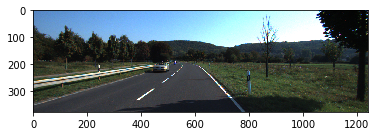

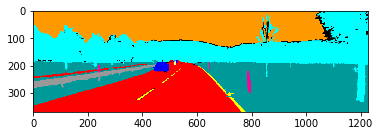

In [7]:
#@markdown > The number of images to load from the dataset. By default 400 images are loaded.
num_images =  10#@param {type: "number" }

y = list()
for filename in labels_filenames[ 0 : num_images ]:
	label = Image.open(os.path.join(labels_dir, filename))
	w, h = label.size
	# y.append(np.asarray(label.resize((w,h)) )) 
	y.append(np.asarray(label.resize((1226, 370)) )) 



x = list()
for filename in image_filenames[ 0 : num_images ]:
	image = Image.open(os.path.join(image_dir, filename))
	w, h = image.size
	x.append(np.asarray(image.resize((w, h)) ))

x = np.array( x ) / 255
y = np.array( y )

print(y.dtype)
print(y.shape)

# our shit
show_image(x[0])
show_image(y[0])

In [8]:
from sklearn.model_selection import train_test_split

#@markdown > Процент проверочных изображений. По умолчанию 0.4
test_size =  0.4#@param {type: "number" }
train_features, test_features, train_labels, test_labels = train_test_split(np.array(x), np.array(y),test_size=test_size)

In [ ]:
def mapping( pixel ):
  for l in labels:
    if np.array_equal( pixel , l.color):
      return  np.array( [ l.id ] )
  return np.array( [ -1 ] )

train_labels1 = np.apply_along_axis(mapping , axis=3 , arr=train_labels) 
test_labels1 = np.apply_along_axis( mapping , axis=3 , arr=test_labels) 

In [10]:
print(len(train_labels1))
print(train_labels1[0])

6
[[[4]
  [4]
  [4]
  ...
  [6]
  [0]
  [0]]

 [[4]
  [4]
  [4]
  ...
  [6]
  [6]
  [0]]

 [[4]
  [4]
  [4]
  ...
  [6]
  [6]
  [6]]

 ...

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]

 [[2]
  [2]
  [2]
  ...
  [2]
  [2]
  [2]]]
